# Text Cleaning for BoW

In [9]:
import numpy as np
import pandas as pd
import re
import string
import unidecode #pip install unidecode
%matplotlib inline
import matplotlib.pyplot as plt

# Read original csv file
df0 = pd.read_csv('tweets_public.csv', encoding='utf-16', index_col='tweet_id', sep=',')
# Keep relevant columns only
df = df0.drop(['retweet_count','is_reply','reply_count','tweet_coord','tweet_location','user_timezone'], axis=1)
#df.head()

### First Step Data cleaning:
- Convert all tweets to lowercase
- Delete URLs, additional white spaces, twitter vocabulary (RT, via, by), numbers, single characters (e.g. q instead of que) and accents.

In [10]:
def basicCleaning(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Delete URLs www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    #Remove additional white spaces
    tweet = re.sub('\s+', ' ', tweet)
    #Delete via, rt and by
    tweet = re.sub(r'\brt\b','',tweet)
    tweet = re.sub(r'\bvia\b','',tweet)
    tweet = re.sub(r'\bby\b','',tweet)
    # Remove numbers
    tweet = re.sub(r'\d+','',tweet)
    # Remove single characters
    tweet = re.sub(r'\b\w\b','',tweet)
    # Remove accents
    tweet = unidecode.unidecode(tweet)
    return tweet

df['text'] = df['text'].apply(basicCleaning)
#df.head()

### Extract airline names:
- airlinesList was created by reading a list of international airlines and checking which ones appear in our sample. To locate them in the tweets it is necessary to use regular expressions because some of their names are variable (for example, iberia can appear as IB, iberia or iberi if the word is cutted at the end of the tweet).
- Some tweets (558) have no associated airline. This is either because the tweet does not explicitly mention the name of the airline (it is a reply of another tweet) or because the length of the field 'text' is limited and the airline was mentioned at the end.
- Aena was added in the list to check its relevance

In [11]:
airlinesList = ['aena','aeromar','aeromexico','aireuropa','airmadrid','airnostrum','americanairlines',
     'avianca','blueair','britishairways','easyjet','emirates','eurowings','flybe','iberia','klm',
     'lufthansa','niki','norwegian','qatar','ryanair','spanair','spiritairlines',
     'tame','vasp','volaris','vueling','westjet','wizzair']
patterns = [re.compile(r'aena'),re.compile(r'aeromar?'),
            re.compile(r'aeromexi?c?o?'),re.compile(r'aireurop?a?'),
            re.compile(r'airmadr?i?d?'),re.compile(r'airnostru?m?'),
            re.compile(r'americanair?l?i?n?e?s?'),re.compile(r'avianca'),re.compile(r'blueai?r?'),
            re.compile(r'britisha?i?r?w?a?y?s?'),re.compile(r'easyjet'),
            re.compile(r'emitares'),re.compile(r'eurowings'),re.compile(r'flybe'),
            re.compile(r'ibe?r?i?a?'),re.compile(r'klm'),
            re.compile(r'lufthansa'),re.compile(r'niki'),re.compile(r'norwegian'),
            re.compile(r'quatara?i?r?'),re.compile(r'ryanai?r?'),
            re.compile(r'spanai?r?'),re.compile(r'spiritairl?i?n?e?s?'),
            re.compile(r'tame'),re.compile(r'vasp'),re.compile(r'volaris'),
            re.compile(r'vueling'),re.compile(r'westjet'),re.compile(r'wizza?i?r?')]

def extract_airline(tweet):
    noms = str()
    i = 0
    for airline in patterns:
        match = re.search(airline, tweet)
        if match : noms = noms+'|'+airlinesList[i]
        i = i + 1
    if (len(noms) == 0): 
        noms = 'noairline'
    else:
        noms = noms[1:]
    return noms
 
df['airline'] = df['text'].apply(extract_airline)

In [12]:
# From 'airline' column create a one-hot encoding matrix for airline name
tweet_airline = df['airline'].str.split(r'|', expand=True).stack().reset_index(level='tweet_id')
tweet_airline.columns = ['tweet_id','airline']
tweet_airline = tweet_airline.set_index('tweet_id')
# One-hot encoding for airline name
onehot = pd.get_dummies(tweet_airline['airline'])
df_airlines = onehot.groupby('tweet_id').sum()

# Concatenate the two dataframes (original+one-hot airlines) and delete the airline column
merged = pd.concat([df, df_airlines], axis=1, join_axes=[df.index])
df1 = merged.drop('airline', axis=1)

### Second Step Data cleaning
- Remove all users (relevant airline information is already in the dataFrame) and punctuation

In [13]:
def moreCleaning(tweet):
    #Delete @usernames
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove punctuation (includes @, \ and #)
    regex = re.compile('[%s]' % re.escape(string.punctuation+u"¡"+u"¿"+u"€"))
    tweet = re.sub(regex,'',tweet)
    return tweet

df1['text'] = df1['text'].apply(moreCleaning)
#df1.head()

### Tokenizing
Define a list with all word-vectors in the text and remove Spanish stopwords and words such as ['volar','vuelo','vuelos','aerolinea','destino','hacer','si','puede','favor']

In [14]:
from nltk.tokenize import word_tokenize
df1['tokens'] = df1['text'].apply(word_tokenize)

In [23]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('spanish'))
# Remove accents
stopWordsNoAccents = [unidecode.unidecode(w) for w in stopWords]
# Add extra airline vocabulary
newstopWords = stopWordsNoAccents+airlinesList+['volar','vuelo','vuelos','aerolinea',
                                                'destino','destinos','hacer','si','puede',
                                                'favor','click']

def removeStopWords(tweet):
    wordsFiltered = []
    for word in tweet:
        if word not in newstopWords:
            wordsFiltered.append(word.strip())
    return wordsFiltered

df1['wordsFiltered'] = df1['tokens'].apply(removeStopWords)

Transform the lists of filtered words into one single string per airline sentiment to retrieve it to WordCloud

In [24]:
def jointokens(frame):
    tokens_list = frame['wordsFiltered'].tolist()
    sentence = [' '.join(w) for w in tokens_list]
    allsentences = ' '.join(sentence)
    return allsentences

all_text = df1.groupby('airline_sentiment').apply(jointokens)

In [25]:
from wordcloud import WordCloud, STOPWORDS

def plot_WordCloud(stringplot):
    # STOPWORDS: Nombres aerolíneas y palabras del tema y/o generales
    ignore = ''
    wc = {'width': 600, 'height': 300, 'random_state': 0}
    fwc = {'stopwords': ignore, **wc}
    wordcloud = WordCloud(**fwc).generate(stringplot)
    plt.imshow(wordcloud)
    plt.axis("off")

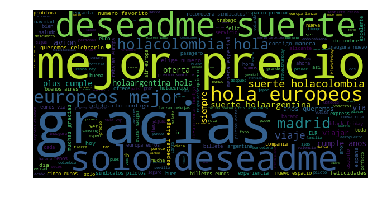

In [26]:
plot_WordCloud(all_text['positive'])

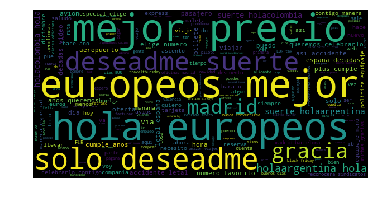

In [27]:
plot_WordCloud(all_text['neutral'])

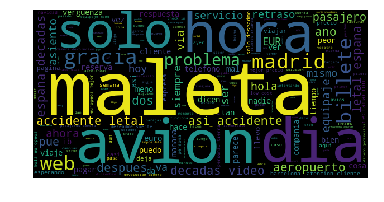

In [28]:
plot_WordCloud(all_text['negative'])